In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from src.data.helicopter import HelicopterAutoencoderDataset
from src.models.autoencoder import AutoEncoderGarcia2020

c:\Users\maxho\anaconda3\envs\transformer-anomaly-detection\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = HelicopterAutoencoderDataset()

train_proportion = 0.8
train_size = int(len(train_data) * train_proportion)
valid_size = len(train_data) - train_size

train_data, valid_data = torch.utils.data.random_split(
    dataset=train_data,
    lengths=[train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
)

In [3]:
transformer = torch.load("checkpoints/Morvan2022-helicopter-random noise-complete-4.save").to("cuda")
autoencoder = AutoEncoderGarcia2020().to("cuda")

In [4]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="mean")

In [5]:
epochs = 1

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}:")

    transformer.eval()
    autoencoder.train()

    running_loss = 0
    running_samples = 0

    for timeseries in tqdm(train_data, desc="Training ..."):

        optimizer.zero_grad()

        with torch.no_grad():
            windows = torch.concat([timeseries.reshape(120, 512)]).unsqueeze(dim=-1)

            batch_size = 20

            attention_maps = []
            
            for i in range(6):
                batch = windows[i*batch_size:(i+1)*batch_size].to("cuda")
                
                batch_pred, attention_map = transformer(batch)
                attention_map = attention_map[:, -1, :, :, :] # Take last layer
                attention_map = nn.AvgPool2d(kernel_size=8, stride=8)(attention_map)
                attention_maps.append(attention_map)

            images = torch.concat(attention_maps, dim=0).reshape(1, -1, 64, 64)
            images = (images - images.min())/(images.max() - images.min())

            images_batch = images.swapaxes(0, 1)
            images_batch = images_batch.reshape((120, 8, 64, 64))

        pred_images = autoencoder(images_batch)

        loss = criterion(pred_images, images_batch)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        running_samples += 1

    train_loss = running_loss / running_samples
    
    print(f"Epoch {epoch+1}/{epochs}, Train loss: {train_loss}")

Epoch 1:


Training ...: 100%|██████████| 1341/1341 [04:00<00:00,  5.58it/s]

Epoch 1/1, Train loss: 0.0017501823528580185


In [6]:
# torch.save(autoencoder, "autoencoder.save")

In [7]:
pred_images = autoencoder(images_batch)

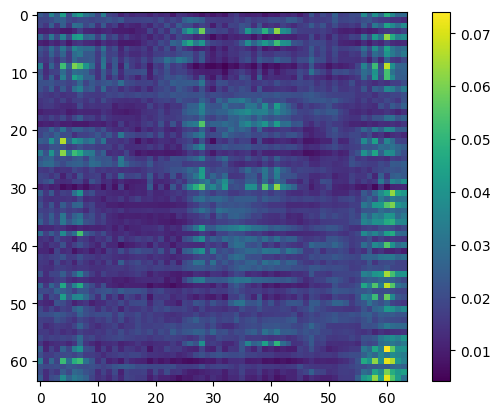

In [8]:

plt.imshow(images_batch[0][7].cpu())
plt.colorbar()

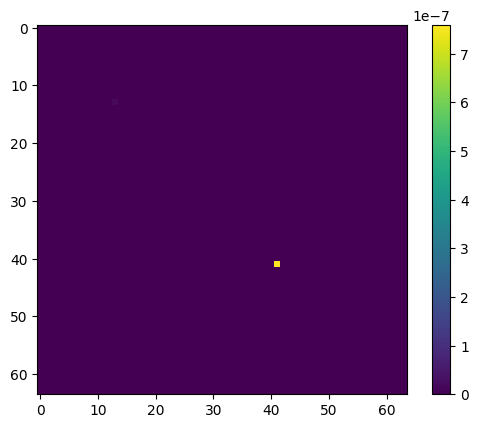

In [9]:
plt.imshow(pred_images[0][7].detach().cpu())
plt.colorbar()